# Binomial-tree vs Black-Scholes pricing

**Objectives**
- Implement a Cox–Ross–Rubinstein (CRR) binomial tree for European calls/puts.
- Compare binomial prices to Black–Scholes closed-form prices.
- Show convergence to Black-Scholes as the number of steps $N$ increases.
- Discuss financial relevance.

**References**
- Shreve, *Stochastic Calculus for Finance II*, Black-Scholes chapters.
- Shreve, *Stochastic Calculus for Finance I*, Binomial-tree chapters.
- Hull, *Options, Futures, and Other Derivatives*, chapters on BS formula and the Binomial-tree.
- Cox, Ross & Rubinstein (1979) – "Option Pricing: A Simplified Approach"


## Imports and configuration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from option_pricing.pricing_binomial import binom_call_from_inputs
from option_pricing.models.bs import bs_call_from_inputs
from option_pricing.types import PricingInputs
np.random.seed(0)

# Some default parameters we will be using later.
params = PricingInputs(
    t=0.0,
    S=100.0,
    K=100.0,
    r=0.02,
    sigma=0.2,
    T=1.0,
)


## CRR Binomial Model Definition (Theory + Implementation)

## Theory recap
A binomial tree is a **discrete-time model** for the evolution of a stock price. Time is divided into steps of length $\Delta t$, and at each step the stock either moves **up by a factor $u$** or **down by a factor $d$**. Starting from $S_0$, this generates all possible stock prices up to the option's maturity $T=n\Delta t$.

We make the following standard assumptions (so that the model is arbitrage-free and complete):

### Market Assumptions

* Trading is **frictionless**: no transaction costs, assets can be traded in any volume, and short-selling is allowed.
* There is a **risk-free money-market account** that earns a constant continuously compounded rate $r$. Over one time step, one unit grows to
    $$R=e^{r\Delta t}.$$

---

### Stock Process Assumptions

* At each step, the stock moves to either $uS_k$ (up) or $dS_k$ (down), with $0<d<u$.
* The parameters satisfy
    $$d<R<u,$$
    which rules out arbitrage and ensures the existence of a risk-neutral probability.

---

### Risk-Neutral Pricing

To price an option, we work under a **risk-neutral measure $\mathbb{Q}$** in which every asset has expected return $r$. In this measure the discounted stock price is a martingale, which in the binomial model implies the **risk-neutral probability** $p$:
$$p = \frac{R - d}{u-d} = \frac{e^{r\Delta t} - d}{u-d},$$
with $0<p<1$ guaranteed by $d<R<u$.

Let $V_k$ be the option value at time $t_k = k\Delta t$, and let $\mathcal{F}_k$ be the information (the sigma-algebra) up to time $t_k$. The **fundamental risk-neutral pricing relation** is:
$$V_k = e^{-r\Delta t}\,\mathbb{E}^{\mathbb{Q}}[\,V_{k+1} \mid \mathcal{F}_k\,].$$
In the one-step binomial setting this becomes the **backward induction formula**:
$$V_k = e^{-r\Delta t}\Big(p\,V_{k+1}^{(u)} + (1-p)\,V_{k+1}^{(d)}\Big),$$
where $V_{k+1}^{(u)}$ and $V_{k+1}^{(d)}$ denote the option values at the up- and down-nodes one step ahead.

---

### Connecting to Black–Scholes (CRR Model)

To connect the binomial model to the Black--Scholes setting, we choose the **Cox–Ross–Rubinstein (CRR) parameters**:
$$u = e^{\sigma\sqrt{\Delta t}}, \qquad d = e^{-\sigma\sqrt{\Delta t}},$$
so that, as $\Delta t \to 0$, the mean and variance of log-returns over a single step match those of a geometric Brownian motion with volatility $\sigma$. With this choice of $u$ and $d$, repeated application of the recursion above yields binomial prices that converge to:
$$V_0 = e^{-rT} \sum_{j=0}^{N} \binom{N}{j} p^{j}(1-p)^{N-j} g(S_0 u^j d^{N-j})$$

---

### Binomial trees beyond European options (context only)

Although we use the CRR tree here only for European calls/puts, the same framework is much more flexible than the closed-form Black–Scholes formula:

### Implementation
For the implementation of the CRR model,  we use function `binom_call_from_inputs` from the `pricing_binomial.py` module. This function assumes a european option.

TODO: maybe a numerical example?

### Sanity checks

## Comparison of BS and Binomtree for European options

## Convergence experiment
### Convergence in N

In [2]:
Ns = [5, 10, 25, 50, 100, 250, 500, 1000]
binom_prices = [binom_call_from_inputs(params, steps) for steps in Ns]
bs_price     = bs_call_from_inputs(params)

# 1. Create the DataFrame using a dictionary
data = {
    'N': Ns,
    'bin_price': binom_prices
}

# Create pandas df from data
convergence_df = pd.DataFrame(data)

# 2. Add the constant bs_price column
convergence_df["bs_price"] = bs_price

# 3. Calculate the absolute error
convergence_df["abs_error"] = np.abs(convergence_df["bs_price"]-convergence_df["bin_price"])
# 4. Set N as the index (as it's the subject of the comparison)
convergence_df = convergence_df.set_index('N')

# 5. Format all relevant columns for professional display
format_mapping = {
    'bin_price': '${:.4f}'.format,
    'bs_price': '${:.4f}'.format,
    'abs_error': '{:.6f}'.format  # Use higher precision for error
}

for col, f in format_mapping.items():
    convergence_df[col] = convergence_df[col].apply(f)

print(convergence_df)

     bin_price bs_price abs_error
N                                
5      $9.3088  $8.9160  0.392713
10     $8.7207  $8.9160  0.195354
25     $8.9936  $8.9160  0.077521
50     $8.8765  $8.9160  0.039524
100    $8.8962  $8.9160  0.019788
250    $8.9081  $8.9160  0.007921
500    $8.9121  $8.9160  0.003962
1000   $8.9141  $8.9160  0.001981


### Comparison plots

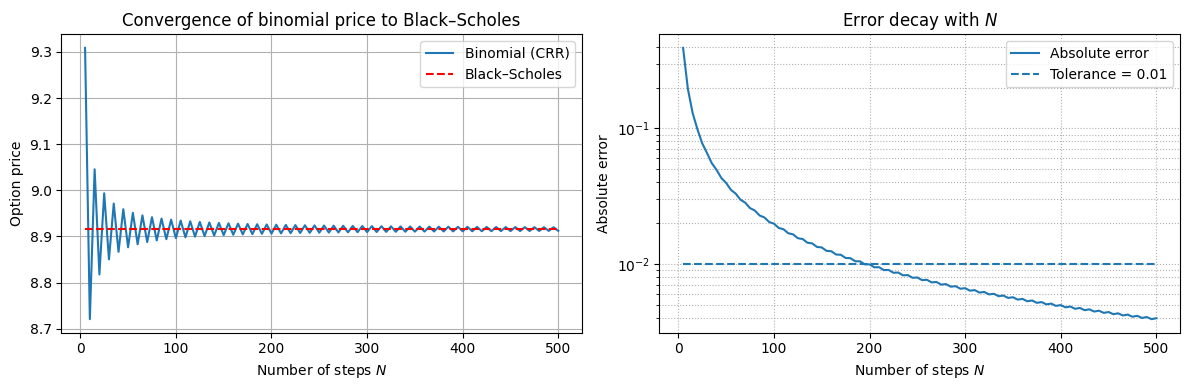

In [5]:
n_steps_max = 500
n_steps_vals = np.arange(5, n_steps_max+1, step=5)
binom_price_vals = [binom_call_from_inputs(params, steps) for steps in n_steps_vals]
abs_error_vals = np.abs(bs_price-binom_price_vals)
tol = 1e-2

fig, (ax_price, ax_err) = plt.subplots(1, 2, figsize=(12, 4))

# --- left: price vs N ---
ax_price.plot(n_steps_vals, binom_price_vals, label="Binomial (CRR)")
ax_price.hlines(bs_price,
                n_steps_vals.min(), n_steps_vals.max(), color='r',
                linestyles="dashed", label="Black–Scholes")
ax_price.set_xlabel("Number of steps $N$")
ax_price.set_ylabel("Option price")
ax_price.set_title("Convergence of binomial price to Black–Scholes")
ax_price.legend()
ax_price.grid(True)

# --- right: error vs N (log scale + tolerance) ---
tol = 1e-2  # example tolerance
ax_err.plot(n_steps_vals, abs_error_vals, label="Absolute error")
ax_err.hlines(tol,
              n_steps_vals.min(), n_steps_vals.max(),
              linestyles="dashed", label=f"Tolerance = {tol:.2g}")
ax_err.set_xlabel("Number of steps $N$")
ax_err.set_ylabel("Absolute error")
ax_err.set_yscale("log")
ax_err.set_title("Error decay with $N$")
ax_err.legend()
ax_err.grid(True, which="both", ls=":")

fig.tight_layout()
plt.show()


### price vs N
- Note convergence as N increases
- Osilations by even/odd N

### error vs N
- Monotone error decay
- Note Liniear roughly linear relation for bigger N
- Explain tolerance line


### Takeways
Binomial converges to BS as N increases.
Note how fast it becomes “good enough”.
Any visible oscillations or diminishing returns at large N.